In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

from sklearn.preprocessing import StandardScaler,OrdinalEncoder

from sklearn.metrics import r2_score

from sklearn.model_selection import cross_val_score

from sklearn.model_selection import KFold

from sklearn.pipeline import Pipeline

from sklearn.compose import ColumnTransformer

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression

from sklearn.ensemble import RandomForestRegressor

from xgboost import XGBRegressor

from sklearn.model_selection import KFold

from sklearn import set_config

from sklearn.metrics import r2_score

from sklearn.metrics import mean_absolute_error

from ipywidgets import interact, widgets, Button, Output

In [2]:
def read_csv(file_path):

    return pd.read_csv(file_path)

def dataset_info_statistics(data):

    print("Dataset Information:")
    print(data.info())
    print("\n")

    print("Basic Statistics for Numerical Columns:")
    print(data.describe())
    print("\n")

def check_null(data):

    null_counts = data.isnull().sum()
    print("Null Values in the Dataset:")
    return null_counts


def check_duplicates(data):

    return data.duplicated().any()


def plot_graph(data):
    numerical_columns = data.select_dtypes(include=np.number).columns
    categorical_columns = data.select_dtypes(include='object').columns

    total_columns = len(numerical_columns) + len(categorical_columns)
    total_rows = (total_columns + 2) // 3

    plt.figure(figsize=(15, total_rows * 5))

    i = 1

    for column in numerical_columns:
        plt.subplot(total_rows, 3, i)
        sns.distplot(data[column], kde=True)
        plt.title(f"Histogram for {column}")
        plt.xlabel(column)
        plt.ylabel("Frequency")
        i += 1

    for column in categorical_columns:
        plt.subplot(total_rows, 3, i)
        sns.countplot(data=data, x=column, order=data[column].value_counts().index)
        plt.title(f'Countplot for {column}')
        plt.xlabel(column)
        plt.ylabel('Count')
        plt.xticks(rotation=45)
        i += 1

    plt.tight_layout()
    plt.show()


def seperate_features_target(data,target_column):

    X = data.drop(columns=[target_column],axis=1)
    y = data[target_column]

    return X,y


def perform_train_test_split(X, y, test_size=0.20, random_state=42):

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    return X_train, X_test, y_train, y_test

In [3]:
calories = read_csv('/content/calories.csv')
exercise = read_csv('/content/exercise.csv')

In [4]:
data = pd.merge(calories, exercise, on='User_ID')

In [5]:
data.head()

,User_ID,Calories,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp
0,14733363,231.0,male,68,190.0,94.0,29.0,105.0,40.8
1,14861698,66.0,female,20,166.0,60.0,14.0,94.0,40.3
2,11179863,26.0,male,69,179.0,79.0,5.0,88.0,38.7
3,16180408,71.0,female,34,179.0,71.0,13.0,100.0,40.5
4,17771927,35.0,female,27,154.0,58.0,10.0,81.0,39.8


In [6]:
dataset_info_statistics(data)

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 15000 entries, 0 to 14999
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   User_ID     15000 non-null  int64  
 1   Calories    15000 non-null  float64
 2   Gender      15000 non-null  object 
 3   Age         15000 non-null  int64  
 4   Height      15000 non-null  float64
 5   Weight      15000 non-null  float64
 6   Duration    15000 non-null  float64
 7   Heart_Rate  15000 non-null  float64
 8   Body_Temp   15000 non-null  float64
dtypes: float64(6), int64(2), object(1)
memory usage: 1.1+ MB
None


Basic Statistics for Numerical Columns:
            User_ID      Calories           Age        Height        Weight  \
count  1.500000e+04  15000.000000  15000.000000  15000.000000  15000.000000   
mean   1.497736e+07     89.539533     42.789800    174.465133     74.966867   
std    2.872851e+06     62.456978     16.980264     14.258114     15.03565

In [7]:
check_null(data)

Null Values in the Dataset:


User_ID       0
Calories      0
Gender        0
Age           0
Height        0
Weight        0
Duration      0
Heart_Rate    0
Body_Temp     0
dtype: int64

In [8]:
check_duplicates(data)

False

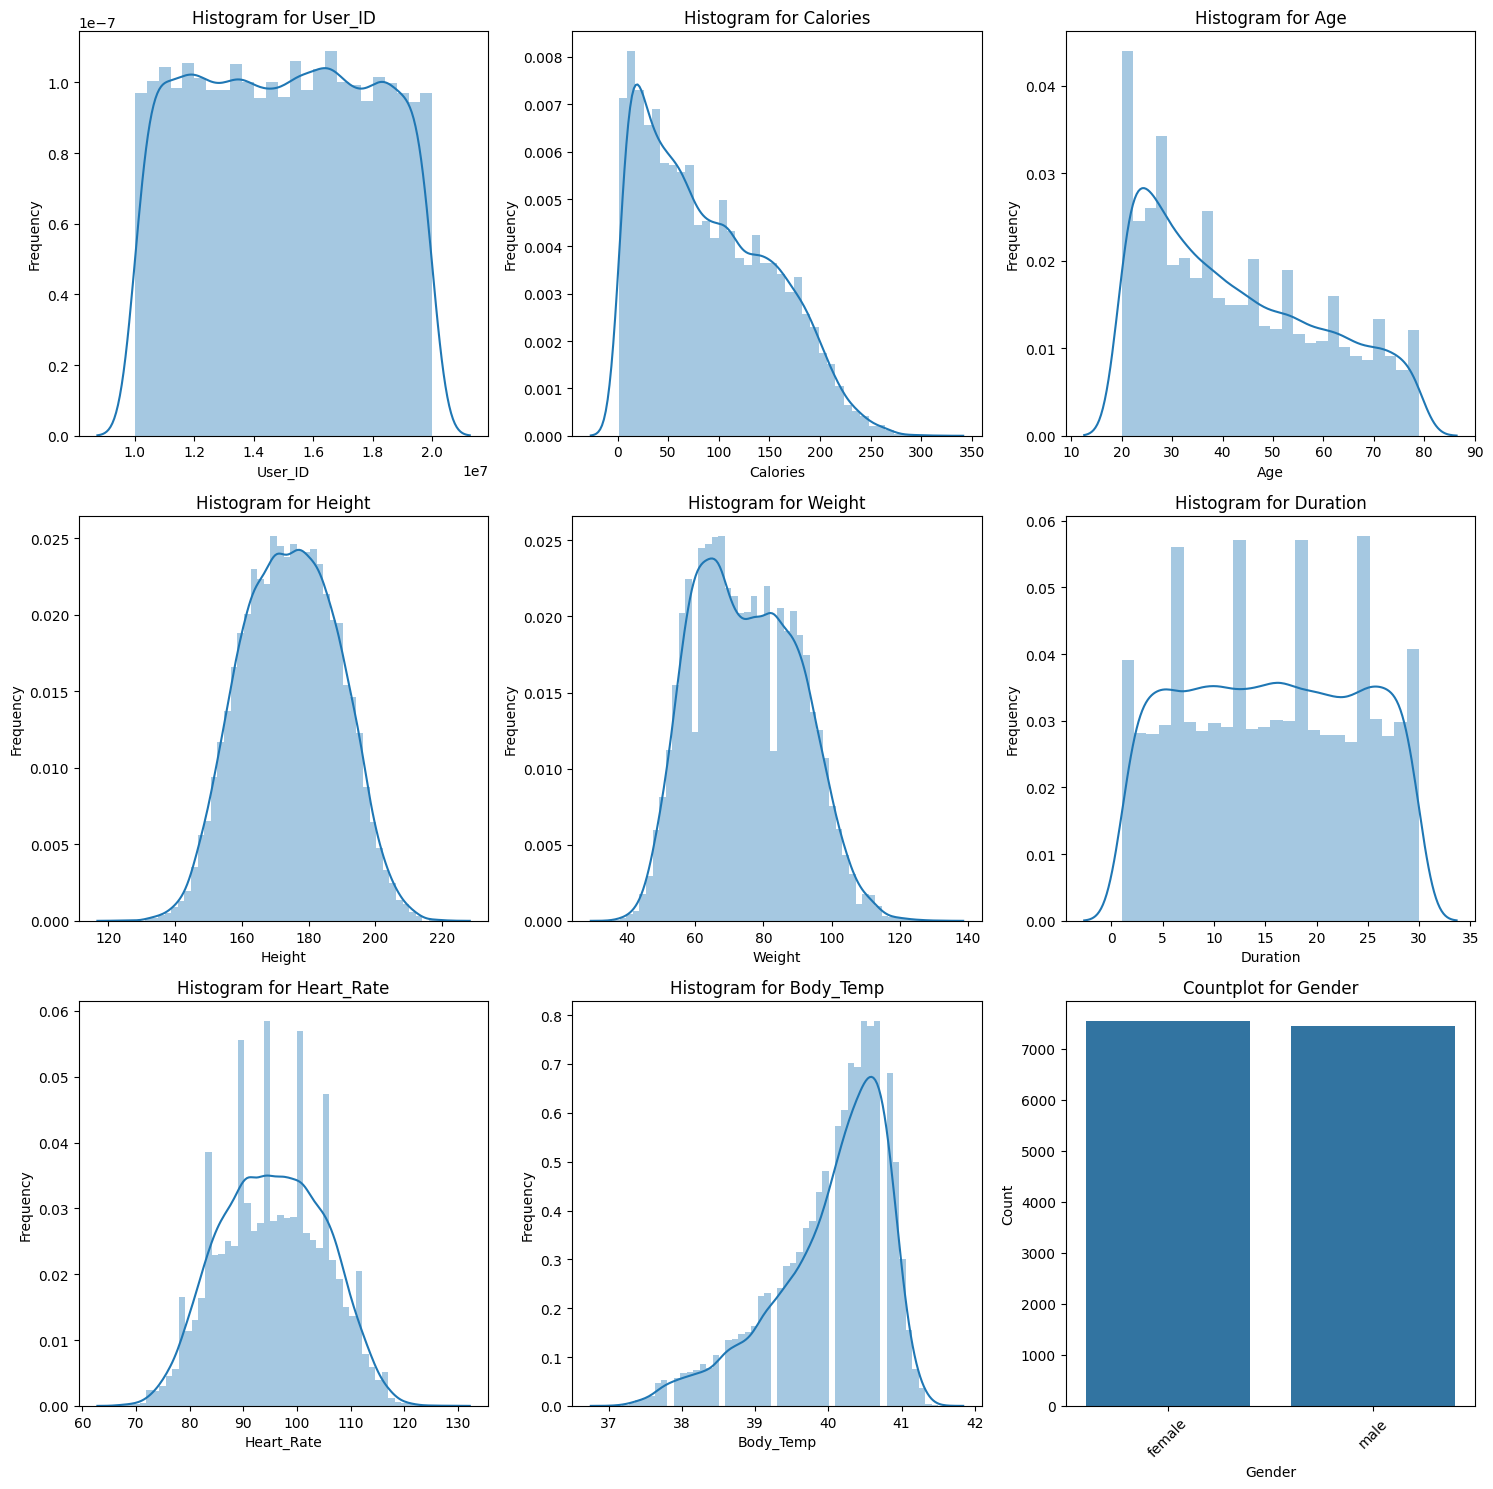

In [9]:
plot_graph(data)

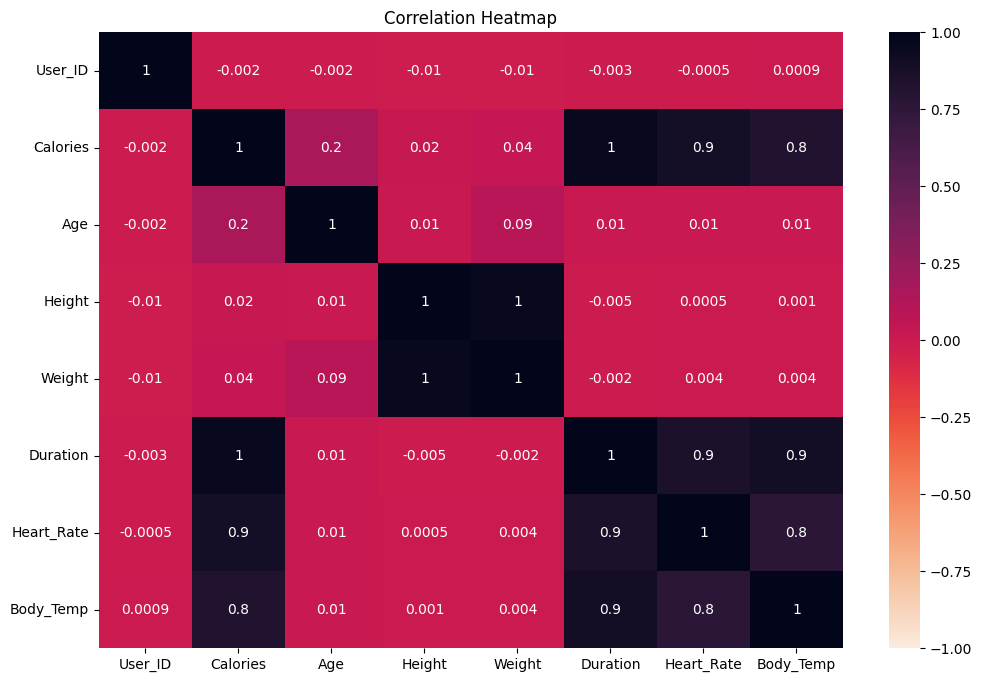

In [10]:
plt.figure(figsize=(12, 8))
sns.heatmap(data.corr(), annot=True, fmt=".1g", vmin=-1, vmax=1, cmap="rocket_r")
plt.title("Correlation Heatmap")
plt.show()


In [11]:
data.columns

Index(['User_ID', 'Calories', 'Gender', 'Age', 'Height', 'Weight', 'Duration',
       'Heart_Rate', 'Body_Temp'],
      dtype='object')

In [12]:
X,y = seperate_features_target(data,'Calories')

In [13]:
X = X.drop(columns=['User_ID'])

In [14]:
X.head()

,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp
0,male,68,190.0,94.0,29.0,105.0,40.8
1,female,20,166.0,60.0,14.0,94.0,40.3
2,male,69,179.0,79.0,5.0,88.0,38.7
3,female,34,179.0,71.0,13.0,100.0,40.5
4,female,27,154.0,58.0,10.0,81.0,39.8


In [15]:
X_train,X_test,y_train,y_test = perform_train_test_split(X, y, test_size=0.20, random_state=42)

In [16]:
preprocessor = ColumnTransformer(transformers=[
    ('ordinal',OrdinalEncoder(),['Gender']),
    ('num',StandardScaler(),['Age',
                            'Height',
                            'Weight',
                            'Duration',
                            'Heart_Rate',
                            'Body_Temp']),
],remainder='passthrough')

In [17]:
X_transformed = preprocessor.fit_transform(X)

feature_names_out = preprocessor.get_feature_names_out()

transformed_df = pd.DataFrame(X_transformed, columns=feature_names_out)
print("Transformed DataFrame:")
print(transformed_df)

Transformed DataFrame:
       ordinal__Gender  num__Age  num__Height  num__Weight  num__Duration  \
0                  1.0  1.484726     1.089582     1.265909       1.619127   
1                  0.0 -1.342179    -0.593726    -0.995458      -0.183990   
2                  1.0  1.543620     0.318066     0.268247      -1.265861   
3                  0.0 -0.517665     0.318066    -0.263839      -0.304198   
4                  0.0 -0.929922    -1.435380    -1.128480      -0.664821   
...                ...       ...          ...          ...            ...   
14995              0.0 -1.342179     1.299996     0.733822      -0.544614   
14996              0.0 -0.929922    -0.663864    -0.662904      -1.145653   
14997              0.0  0.012379    -1.084691    -1.128480       0.056426   
14998              1.0  2.073665     1.299996     1.465441      -1.626484   
14999              1.0  1.190257    -0.102761     0.268247       0.296841   

       num__Heart_Rate  num__Body_Temp  
0          

In [18]:
pipeline = Pipeline([("preprocessor",preprocessor),
                     ("model",LinearRegression())
                    ])

In [19]:
set_config(display='diagram')

In [20]:
pipeline.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinal', OrdinalEncoder(),
                                                  ['Gender']),
                                                 ('num', StandardScaler(),
                                                  ['Age', 'Height', 'Weight',
                                                   'Duration', 'Heart_Rate',
                                                   'Body_Temp'])])),
                ('model', LinearRegression())])

In [21]:
y_pred = pipeline.predict(X_test)

In [22]:
r2_score(y_test,y_pred)

0.9672937151257295

In [23]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

In [24]:
cv_results = cross_val_score(pipeline, X, y, cv=kfold, scoring='r2')

In [25]:
cv_results.mean()

0.9671402283675841

In [26]:
mean_absolute_error(y_test,y_pred)

8.441513553849704

In [27]:
def model_scorer(model_name,model):

    output=[]


    output.append(model_name)

    pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model',model)])

    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.20,random_state=42)

    pipeline.fit(X_train,y_train)

    y_pred = pipeline.predict(X_test)

    output.append(r2_score(y_test,y_pred))
    output.append(mean_absolute_error(y_test,y_pred))

    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_results = cross_val_score(pipeline, X, y, cv=kfold, scoring='r2')
    output.append(cv_results.mean())

    return output

In [28]:
model_dict={
    'LR':LinearRegression(),
    'RF':RandomForestRegressor(),
    'XGBR':XGBRegressor(),
}

In [29]:
model_output=[]
for model_name,model in model_dict.items():
    model_output.append(model_scorer(model_name,model))

In [30]:
model_output

[['LR', 0.9672937151257295, 8.441513553849704, 0.9671402283675841],
 ['RF', 0.9981989043270715, 1.7137899999999997, 0.9979280605330476],
 ['XGBR', 0.9988678909361673, 1.4981198125282924, 0.9988510864545181]]

In [31]:
pipeline = Pipeline([
    ('preprocessor',preprocessor),
    ('model',XGBRegressor())

])

In [32]:
pipeline.fit(X,y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinal', OrdinalEncoder(),
                                                  ['Gender']),
                                                 ('num', StandardScaler(),
                                                  ['Age', 'Height', 'Weight',
                                                   'Duration', 'Heart_Rate',
                                                   'Body_Temp'])])),
                ('model',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])

In [33]:
sample = pd.DataFrame({
   'Gender':'male',
    'Age':68,
    'Height':190.0,
    'Weight':94.0,
    'Duration':29.0,
    'Heart_Rate':105.0,
    'Body_Temp':40.8,
},index=[0])

In [34]:
pipeline.predict(sample)

array([231.0721], dtype=float32)

In [35]:
with open('pipeline.pkl','wb') as f:
    pickle.dump(pipeline,f)

In [36]:
with open('pipeline.pkl','rb') as f:
    pipeline_saved = pickle.load(f)

In [37]:
result = pipeline_saved.predict(sample)

In [38]:
result

array([231.0721], dtype=float32)

In [39]:
from IPython.display import display, HTML
import ipywidgets as widgets

options = ['male', 'female']
clicked = widgets.Dropdown(options=options, value=options[0], description='<div style="text-align: left;">Gender:</div>')
e2 = widgets.FloatText(value=0, description='<div style="text-align: left;">Age:</div>')
e3 = widgets.FloatText(value=0, description='<div style="text-align: left;">Height:</div>')
e4 = widgets.FloatText(value=0, description='<div style="text-align: left;">Weight:</div>')
e5 = widgets.FloatText(value=0, description='<div style="text-align: left;">Duration:</div>')
e6 = widgets.FloatText(value=0, description='<div style="text-align: left;">Heart Rate:</div>')
e7 = widgets.FloatText(value=0, description='<div style="text-align: left;">Body Temp:</div>')

e7.layout.margin = '0 0 15px 0'

output = widgets.Output()

def show_entry(clicked, e2, e3, e4, e5, e6, e7):
    with open('pipeline.pkl', 'rb') as f:
        pipeline = pickle.load(f)

    p1 = str(clicked)
    p2 = float(e2)
    p3 = float(e3)
    p4 = float(e4)
    p5 = float(e5)
    p6 = float(e6)
    p7 = float(e7)

    sample = pd.DataFrame({
        'Gender': [p1],
        'Age': [p2],
        'Height': [p3],
        'Weight': [p4],
        'Duration': [p5],
        'Heart_Rate': [p6],
        'Body_Temp': [p7],
    }, index=[0])

    result = pipeline.predict(sample)
    with output:
        output.clear_output(wait=True)
        display(HTML(f"<div style='text-align: center; font-size: 18px; color: Green;'>Amount of Calories Burnt: {result[0]}</div>"))

def predict_button_clicked(b):
    show_entry(clicked.value, e2.value, e3.value, e4.value, e5.value, e6.value, e7.value)

predict_button = widgets.Button(description="Predict", button_style='success')
predict_button.on_click(predict_button_clicked)

form_layout = widgets.Layout(display='flex', flex_flow='column', align_items='center')
form_items = [clicked, e2, e3, e4, e5, e6, e7, widgets.HTML('<br>'), predict_button, output]
form = widgets.Box(form_items, layout=form_layout)
display(form)


Box(children=(Dropdown(description='<div style="text-align: left;">Gender:</div>', options=('male', 'female'),…